In [1]:
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx
import diffrax as dfx

from flex import FuzzyVariable
from flex.fiss import TSK
from flex.utils import count_parameters
from flex.utils.types import Array

In [2]:
def run_random_traj(ts, *, key):
    y0 = jr.uniform(key, (2,), minval=-0.6, maxval=1.0)

    def f(t, y, args):
        x = y / (y + 1.0)
        return jnp.stack([x[1], -x[0]])

    sol = dfx.diffeqsolve(
        dfx.ODETerm(f),
        dfx.Tsit5(),
        ts[0],
        ts[-1],
        0.1,
        y0,
        saveat=dfx.SaveAt(ts=ts)
    )

    return sol.ys

In [3]:
def get_data(dataset_size, *, key):
    ts = jnp.linspace(0.0, 10.0, 100)
    keys = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: run_random_traj(ts, key=key))(keys)
    return ts, ys

In [4]:
def load_data(data, batch_size, *, key):
    dataset_size = data[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in data)
    inds = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, inds)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in data)
            start = end
            end = start + batch_size

In [5]:
class Func(eqx.Module):
    fis: TSK

    def __init__(
        self,
        n_mfs: int,
        order: int,
        init_scale: float,
        *,
        key: Array,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        y = (
            FuzzyVariable.ruspini(n_mfs, minval=-1.0, maxval=1.0, name="x"),
            FuzzyVariable.ruspini(n_mfs, minval=-1.0, maxval=1.0, name="xdot"),
        )

        self.fis = TSK.init(
            input_vars=y,
            n_out=2,
            order=order,
            init_scale=init_scale,
            key=key,
            name="FODE",
        )

    def __call__(self, t, y, args):
        return self.fis(y)
        

In [6]:
class FuzzyODE(eqx.Module):
    func: Func

    def __init__(
        self,
        n_mfs: int,
        # kind: str,
        order: int,
        init_scale: float,
        *,
        key: Array,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.func = Func(
            n_mfs=n_mfs,
            # kind=kind,
            order=order,
            init_scale=init_scale,
            key=key,
        )
    
    def __call__(self, ts, y0):
        sol = dfx.diffeqsolve(
            dfx.ODETerm(self.func),
            dfx.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            # stepsize_controller=dfx.ConstantStepSize(),
            stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6),
            saveat=dfx.SaveAt(ts=ts),
        )

        return sol.ys

In [7]:
dataset_size = 256
batch_size = 128
lr = 5e-3
steps_strategy = (1000, 1000)
length_strategy = (0.1, 1.0)
seed = 12345
print_every = 100

n_mfs = 7
order = 0
init_scale = 1e-2

In [8]:
key = jax.random.PRNGKey(seed)
data_key, model_key, loader_key = jax.random.split(key, 3)

ts, ys = get_data(dataset_size, key=data_key)
_, length_size, _ = ys.shape

model = FuzzyODE(
    n_mfs=n_mfs,
    order=order,
    init_scale=init_scale,
    key=model_key,
)
optim = optax.adam(learning_rate=lr)

In [9]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    return jnp.mean((yi - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [10]:
for steps, length in zip(steps_strategy, length_strategy):
    opt_state = optim.init(model)
    _ts = ts[: int(length_size * length)]
    _ys = ys[:, : int(length_size * length)]
    for step, (yi,) in zip(
        range(steps), load_data((_ys,), batch_size, key=loader_key)
    ):
        start = perf_counter()
        loss, model, opt_state = make_step(_ts, yi, model, opt_state)
        end = perf_counter()
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

Step: 0, Loss: 0.06825707107782364, Computation time: 8.382590531999085
Step: 100, Loss: 0.018742136657238007, Computation time: 0.021561048000876326
Step: 200, Loss: 0.004530677571892738, Computation time: 0.021878303999983473
Step: 300, Loss: 0.0005323645891621709, Computation time: 0.025668536998637137
Step: 400, Loss: 0.0004527030687313527, Computation time: 0.033063909999327734
Step: 500, Loss: 0.00033389765303581953, Computation time: 0.03522346899990225
Step: 600, Loss: 8.973151125246659e-05, Computation time: 0.037682905998735805
Step: 700, Loss: 0.0001525270054116845, Computation time: 0.04045110099832527
Step: 800, Loss: 7.701177673880011e-05, Computation time: 0.03162106399940967
Step: 900, Loss: 8.067770977504551e-05, Computation time: 0.024907920000259764
Step: 999, Loss: 5.6957524066092446e-05, Computation time: 0.03442384600020887
Step: 0, Loss: 0.006891926284879446, Computation time: 8.032581575998847
Step: 100, Loss: 0.0008098374819383025, Computation time: 0.200440409

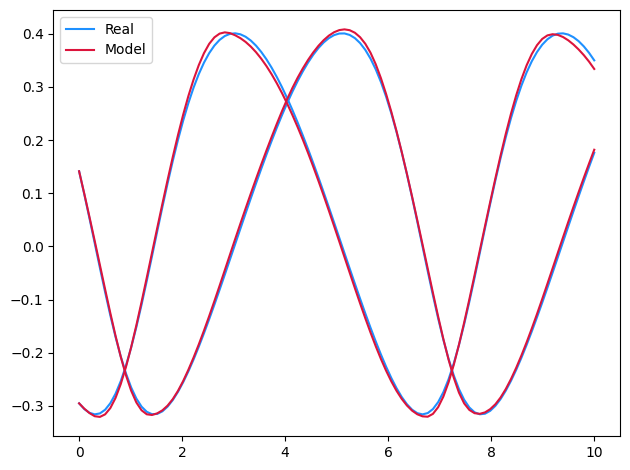

In [ ]:
plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
plt.plot(ts, ys[0, :, 1], c="dodgerblue")
model_y = model(ts, ys[0, 0])
plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
plt.plot(ts, model_y[:, 1], c="crimson")
plt.legend()
plt.tight_layout()
# plt.savefig("neural_ode.png")
plt.show()

In [12]:
count_parameters(model)

208

In [13]:
class MLP(eqx.Module):
    out_scale: jax.Array
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.out_scale = jnp.array(1.0)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jax.nn.softplus,
            final_activation=jax.nn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        # Best practice is often to use `learnt_scalar * tanh(MLP(...))` for the
        # vector field.
        return self.out_scale * self.mlp(y)

In [14]:
m2 = MLP(2, 64, 2, key=jr.PRNGKey(0))

In [15]:
count_parameters(m2)

4483